### WARNING:
#### This notebook could be very slow without a GPU.
##### Note: I've used Nvidia GeForce 1050 ti 4gb.

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
import tensorflow as tf

assert tf.__version__ >= "2.8.0"

In [3]:
import pandas as pd
import numpy as np

np.random.seed(42)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [6]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

2022-09-08 22:20:27.124116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 22:20:27.160461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 22:20:27.160704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [7]:
from tensorflow.data.experimental import save as tf_save

dataset_dir = "/data/asjad/Project/venv/venv/Housing_price/burger_joint/dataset/2000_obs.csv"

In [8]:
try:
    df = pd.read_csv(dataset_dir,
                         parse_dates=["transaction_date_time"])
    df = df.drop("credit_card_number", axis=1) # no need for credit_card_number
    df = df.set_index("transaction_date_time")
    print("Dataset has been loaded")
    
except:
    print('Unable to load dataset')

Dataset has been loaded


In [9]:
df

,cust_id,transaction_amount,transaction_type,day_type
transaction_date_time,,,,
96256,5455,7327,c,w
785459,7208,6986,a,s
1615429,9627,6405,a,w
2664541,9739,1114,d,s
2784743,6778,714,c,s
...,...,...,...,...
1659386968,4546,5925,b,w
1659961410,9909,1192,d,s
1660332534,666,1994,c,s


In [10]:
df['transaction_type'].value_counts()

a    528
c    507
d    496
b    469
Name: transaction_type, dtype: int64

#### Assuming 4 different transactions type:

#### a = food,

#### b = pharm,

#### c = fuel 

#### d = others.

In [11]:
df['day_type'].value_counts()

w    1004
s     996
Name: day_type, dtype: int64

#### Assuming two day types:

#### w = weekdays

#### s = weekend

In [12]:
df.shape

(2000, 4)

In [13]:
df.describe()

,cust_id,transaction_amount
count,2000.000000,2000.000000
mean,5302.983000,4991.493000
std,2740.037284,2892.753406
min,507.000000,101.000000
25%,2946.000000,2404.750000
50%,5259.000000,4882.500000
75%,7683.250000,7550.750000
max,9995.000000,9992.000000


101 is the lowest spending and 9992 is the highest spending


<AxesSubplot:xlabel='transaction_type'>

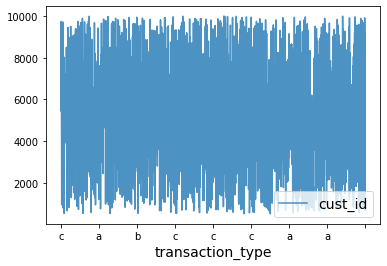

In [14]:
import matplotlib.pyplot as plt

df.plot(kind="line", x="transaction_type", y="cust_id", alpha=0.8)

In [15]:
from datetime import datetime
print("lowest transaction_amount date_time:", datetime.fromtimestamp(70741065))
print("highest transaction_amount date_time:", datetime.fromtimestamp(1030973928))

lowest transaction_amount date_time: 1972-03-29 23:17:45
highest transaction_amount date_time: 2002-09-02 19:38:48


let's see the trend from the begining to the last obs we have

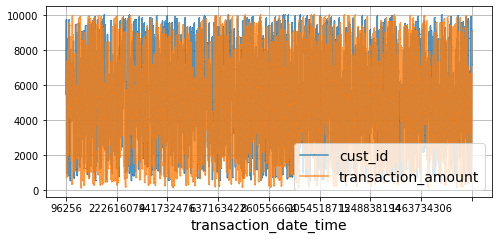

In [16]:
df['96256':'1661580095'].plot(grid=True, marker=',', figsize=(8, 3.5), alpha=0.8)
plt.show()

let's check if after 1972-03-29 23:17:45 any low amount transaction occured till the end 2022-08-27 11:01:35


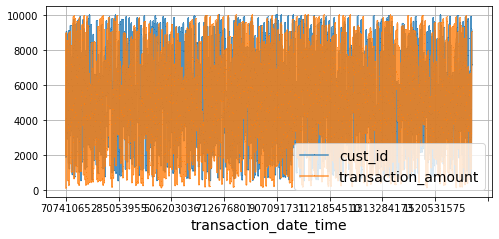

In [17]:
df['70741065':'1661580095'].plot(grid=True, marker=',', figsize=(8, 3.5),
                                  alpha=0.8)
plt.show()

#### There's no such events that shows the transaction amount decreased below 101, after 1972-03-29 23:17:45 till 2022-08-27 11:01:35


In [18]:
#print(datetime.fromtimestamp(1260738756))
#print(datetime.fromtimestamp(1048305858))
print(datetime.fromtimestamp(1661580095))

2022-08-27 11:01:35


#### Hence: The minimum transaction amount is 101, held on 1972-03-29 23:17:45 by cust_id: 9042

#### And the maximum transaction amount is 4998, held on 2002-09-02 19:38:48. by cust_id: 8646

In [19]:
# Checking the daytype on which minimum transactions occured

list(df.loc["70741065"]["day_type"])

['w']

In [20]:
# Checking the daytype on which maximum transactions occured

list(df.loc["1661580095"]["day_type"])

['w']

####  'w' describe the weekday(mon-fri), day_type, therefore we can say that both the lowest and the highest transactions occured on weekend!!

In [21]:
df_mulvar = df[["cust_id", "transaction_amount"]] # using both as inputs
df_mulvar

,cust_id,transaction_amount
transaction_date_time,,
96256,5455,7327
785459,7208,6986
1615429,9627,6405
2664541,9739,1114
2784743,6778,714
...,...,...
1659386968,4546,5925
1659961410,9909,1192
1660332534,666,1994


In [22]:
df_mulvar["day_type"] = df["day_type"].shift(-1)
df_mulvar["transaction_type"] = df["transaction_type"].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar)
df_mulvar


/tmp/ipykernel_21337/2003346083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mulvar["day_type"] = df["day_type"].shift(-1)


,cust_id,transaction_amount,day_type_s,day_type_w,transaction_type_a,transaction_type_b,transaction_type_c,transaction_type_d
transaction_date_time,,,,,,,,
96256,5455,7327,1,0,1,0,0,0
785459,7208,6986,0,1,1,0,0,0
1615429,9627,6405,1,0,0,0,0,1
2664541,9739,1114,1,0,0,0,1,0
2784743,6778,714,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...
1659386968,4546,5925,1,0,0,0,0,1
1659961410,9909,1192,1,0,0,0,1,0
1660332534,666,1994,0,1,0,0,1,0


In [23]:
1096 + 914 + 151

2161

In [24]:
df_mulvar.shape

(2000, 8)

In [25]:
# 60% of the 2000
0.6 * 2000

1200.0

In [26]:
# 30% of the 2000
0.3 * 2000

600.0

In [27]:
# 10% of the 2000
0.1 * 2000

200.0

In [28]:
# split the dataset in 70%, 30%, 30% to train, valid, and test set repectively

mulvar_train = df_mulvar["96256":"1007875248"]
mulvar_valid = df_mulvar["1010586936":"1507568833"]
mulvar_test = df_mulvar["1507726526":]

print("mulvar_train.shape:", mulvar_train.shape)
print("mulvar_valid.shape:", mulvar_valid.shape)
print("mulvar_test.shape:", mulvar_test.shape)

mulvar_train.shape: (1200, 8)
mulvar_valid.shape: (600, 8)
mulvar_test.shape: (200, 8)


In [29]:
mulvar_train

,cust_id,transaction_amount,day_type_s,day_type_w,transaction_type_a,transaction_type_b,transaction_type_c,transaction_type_d
transaction_date_time,,,,,,,,
96256,5455,7327,1,0,1,0,0,0
785459,7208,6986,0,1,1,0,0,0
1615429,9627,6405,1,0,0,0,0,1
2664541,9739,1114,1,0,0,0,1,0
2784743,6778,714,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...
1003797362,7468,269,0,1,0,1,0,0
1004837584,7457,3563,0,1,1,0,0,0
1005057889,9266,8350,1,0,1,0,0,0


In [30]:
tf.random.set_seed(42)
seq_length = 56

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(), # use all 8 columns as input
    targets = mulvar_train['cust_id'][seq_length:], # forecast only the 'cust_id series'
    sequence_length = seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets = mulvar_valid['cust_id'][seq_length:],
    sequence_length = seq_length,
    batch_size=32
)

2022-09-08 22:20:31.788466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 22:20:31.788990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 22:20:31.789388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 22:20:32.346044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 22:20:32.346280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [31]:
train_mulvar_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 8), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [32]:
valid_mulvar_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 8), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [33]:
tf.random.set_seed(42)



In [34]:
import joblib

In [35]:
def fit_and_evaluate(train_set, valid_set, learning_rate, epochs):
    try:
        model = joblib.load("bj_model.pkl")
        print("Model has been loaded")
                    
    except:
        try:
            tf.random.set_seed(42)
            
            model = tf.keras.Sequential([
                tf.keras.layers.SimpleRNN(32, input_shape=[None, 8]),
                tf.keras.layers.Dense(1)
            ])
            
            early_stopping_cb = tf.keras.callbacks.EarlyStopping(
                monitor = "val_mae", patience=50,
                restore_best_weights=True)
            
            opt = tf.keras.optimizers.SGD(learning_rate=0.05,
                                      momentum=0.9)
            
            model.compile(loss=tf.keras.losses.Huber(),
                                 optimizer=opt,metrics=["mae"])
    
            history = model.fit(train_mulvar_ds,
                                       validation_data=valid_mulvar_ds,
                                       epochs=epochs,
                                       callbacks=[early_stopping_cb])

        except:
            model = None
            print("Model is None")
            
        try:
            if model != None:
                joblib.dump(model, "bj_model.pkl")
                print("Model has been saved to disk")
                
            else:
                print("Unable to save model to disk")
                
        except:
            print("Error in model training")
            
    return model

In [36]:
model = fit_and_evaluate(train_mulvar_ds, valid_mulvar_ds,
                 learning_rate= 0.05, epochs=10)

Model has been loaded


In [37]:
valid_loss, valid_mae = model.evaluate(valid_mulvar_ds)
print(valid_loss)
print(valid_mae)
           


17/17 [==============================] - 1s 13ms/step - loss: 2555.6406 - mae: 2556.1404
2555.640625
2556.140380859375


import matplotlib.pyplot as plt

            # summarize the history for loss

            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()

In [38]:
test_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_test.to_numpy(),
    targets = mulvar_test['cust_id'][seq_length:],
    sequence_length=seq_length,
)

In [39]:
test_mulvar_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 8), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [40]:
forecast = model.predict(test_mulvar_ds)

2/2 [==============================] - 0s 11ms/step


In [41]:
forecast

array([[3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],
       [3803.5586],


In [42]:
3803.5586

3803.5586